<a href="https://colab.research.google.com/github/sreya-rc/TF2.0/blob/main/TF2_0_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install TensorFlow
try:
  %tensorflow_version 2.x # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.12.0


In [2]:
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [3]:
# Load in MNIST data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Center data from -1 to 1
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1
print("x_train.shape:", x_train.shape)

11490434/11490434 [==============================] - 0s 0us/step
x_train.shape: (60000, 28, 28)


In [4]:
# Flatten data
N, H, W = x_train.shape     # (60000, 28, 28)
D = H * W                   # 28 * 28
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

In [5]:
# Dimensionality of latent space
latent_dim = 100

In [6]:
# Build generator model
def build_generator (latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(D, activation='tanh')(x)      # use tanh activation function since image pixels are centered between -1 and 1

  model = Model(i, x)
  return model

In [7]:
# Build discriminator model
def build_discriminator (img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)

  model = Model(i, x)
  return model

In [8]:
# Compile both models

# Build and compile the discriminator
discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy']
)

# Build generator and compile the combined model
generator = build_generator(latent_dim)

# Create input to represent noise sample from letent space
z = Input(shape=(latent_dim,))

# Pass noise through generator to get generated image
img = generator(z)

# Train only the generator (freeze the weights in the discriminator)
discriminator.trainable = False

# Pass image (output from generator model) as input into the discriminator model
pred = discriminator(img)

# Create combined model
combined_model = Model(z, pred)

# Compile combined model
combined_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5)
)

In [9]:
# Train the GAN

# Config
batch_size = 32
epochs = 20000
sample_period = 200     # Generate a sample every 200 steps

# Create batch labels
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Store the losses
d_losses = []
g_losses = []

# Create a folder to store generated images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [10]:
# A function to generate a grid of random samples from the generator and save them to a file
def sample_images (epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)

  # Rescale images from 0 - 1
  imgs = 0.5 * imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  idx = 0

  for i in range(rows):
    for j in range(cols):
      axs[i, j].imshow(imgs[idx].reshape(H, W), cmap='gray')
      axs[i, j].axis('off')
      idx += 1

  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()

In [11]:
# Main training loop for the combined_model

for epoch in range(epochs):
  ### Train discriminator ###

  # Select a random batch of images
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]

  # Generate fake images
  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)

  # Train discriminator (both loss ans accuracy are returned)
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
  d_loss = 0.5 * (d_loss_real + d_loss_fake)    # Take the mean value
  d_acc  = 0.5 * (d_acc_real + d_acc_fake)


  ### Train generator ###
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)    # Target is ones since we're trying to trick the generator into thinking the image is real

  # Save the losses
  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if epoch % 100 == 0:
    print(f"epoch: {epoch + 1}/{epochs}, d_loss: {d_loss:.2f}, \
      d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")

  if epoch % sample_period == 0:
    sample_images(epoch)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 28ms/step
epoch: 15101/20000, d_loss: 0.58,       d_acc: 0.73, g_loss: 0.99
1/1 [==============================] - 0s 36ms/step
epoch: 15201/20000, d_loss: 0.56,       d_acc: 0.72, g_loss: 0.88
1/1 [==============================] - 0s 24ms/step
epoch: 15301/20000, d_loss: 0.58,       d_acc: 0.70, g_loss: 0.98
1/1 [==============================] - 0s 28ms/step
epoch: 15401/20000, d_loss: 0.64,       d_acc: 0.67, g_loss: 1.03
1/1 [==============================] - 0s 33ms/step
epoch: 15501/20000, d_loss: 0.61,       d_acc: 0.66, g_loss: 1.04
1/1 [==============================] - 0s 27ms/step
epoch: 15601/20000, d_loss: 0.65,       d_acc: 0.66, g_loss: 0.96
1/1 [==============================] - 0s 24ms/step
epoch: 15701/20000, d_loss: 0.67,       d_acc: 0.56, g_loss: 0.99
1/1 [==============================] - 0s 27ms/step
epoch: 15801/20000, d_loss: 0.71,       d_acc: 0.55, g_loss: 0.98
1/1 [

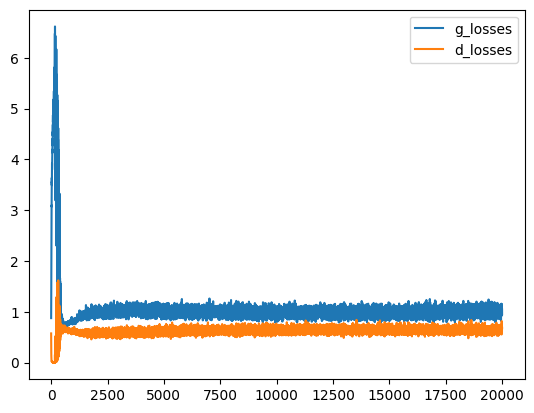

In [12]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

In [13]:
!ls gan_images

0.png	   12400.png  15200.png  18000.png  2600.png  5400.png	800.png
10000.png  12600.png  15400.png  1800.png   2800.png  5600.png	8200.png
1000.png   12800.png  15600.png  18200.png  3000.png  5800.png	8400.png
10200.png  13000.png  15800.png  18400.png  3200.png  6000.png	8600.png
10400.png  13200.png  16000.png  18600.png  3400.png  600.png	8800.png
10600.png  13400.png  1600.png	 18800.png  3600.png  6200.png	9000.png
10800.png  13600.png  16200.png  19000.png  3800.png  6400.png	9200.png
11000.png  13800.png  16400.png  19200.png  4000.png  6600.png	9400.png
11200.png  14000.png  16600.png  19400.png  400.png   6800.png	9600.png
11400.png  1400.png   16800.png  19600.png  4200.png  7000.png	9800.png
11600.png  14200.png  17000.png  19800.png  4400.png  7200.png
11800.png  14400.png  17200.png  2000.png   4600.png  7400.png
12000.png  14600.png  17400.png  200.png    4800.png  7600.png
1200.png   14800.png  17600.png  2200.png   5000.png  7800.png
12200.png  15000.png  17800.png  

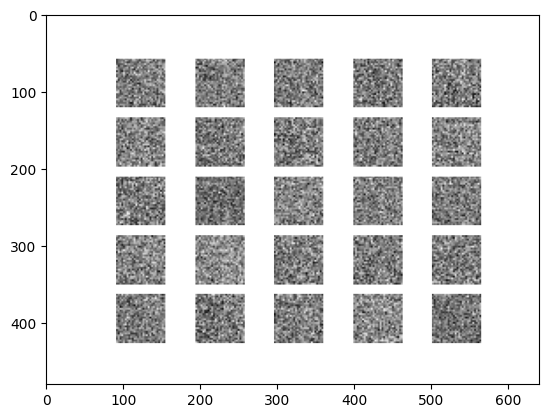

In [14]:
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

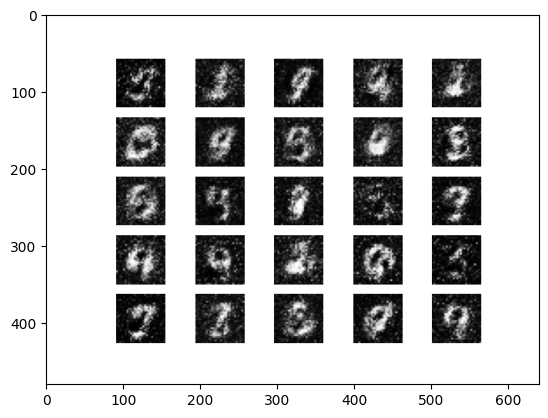

In [15]:
b = imread('gan_images/1000.png')
plt.imshow(b)

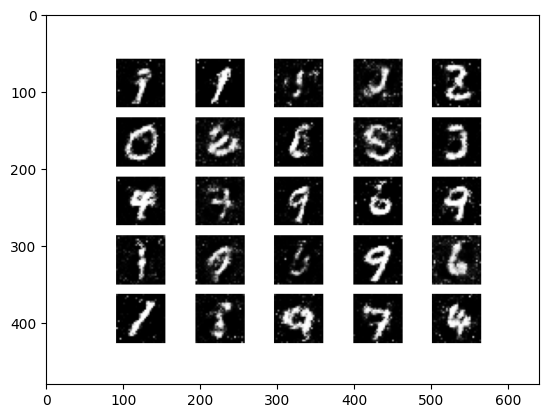

In [16]:
c = imread('gan_images/5000.png')
plt.imshow(c)

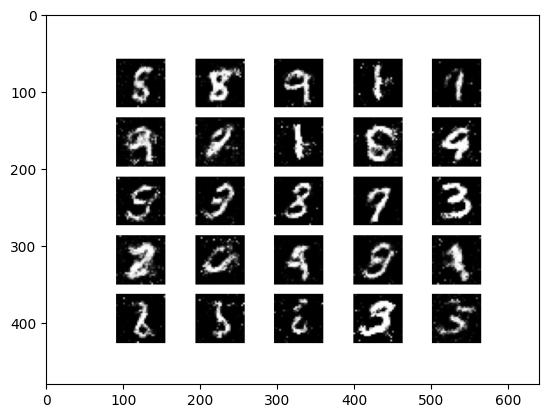

In [17]:
d = imread('gan_images/10000.png')
plt.imshow(d)

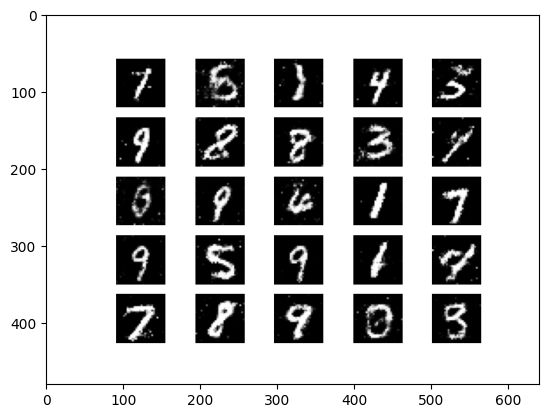

In [18]:
e = imread('gan_images/19800.png')
plt.imshow(e)